In [1]:
from scipy.signal import find_peaks, savgol_filter
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
# import neurokit2 as nk
from tqdm import tqdm
import pandas as pd
import numpy as np
import umap
import h5py

import torch.optim as optim
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import DataLoader, TensorDataset, random_split

import warnings
warnings.filterwarnings("ignore")

In [2]:
device='cpu'

In [3]:
class AttentionLayer(nn.Module):
    """Механизм внимания для временных рядов."""
    def __init__(self, hidden_dim):
        super().__init__()
        self.query = nn.Linear(hidden_dim, hidden_dim)
        self.key = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, x):
        # x: (batch, seq_len, hidden_dim)
        Q = self.query(x)
        K = self.key(x)
        scores = torch.matmul(Q, K.transpose(1, 2)) / torch.sqrt(torch.tensor(x.shape[-1]))
        weights = torch.softmax(scores, dim=-1)
        return torch.matmul(weights, x)

class ECGEncoder(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64):
        super().__init__()
        self.conv1 = nn.Conv1d(input_dim, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.lstm = nn.LSTM(64, hidden_dim, batch_first=True)
        self.attention = AttentionLayer(hidden_dim)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch, 1, seq_len) -> (batch, channels, seq_len)
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.permute(0, 2, 1)  # (batch, seq_len, channels)
        x, _ = self.lstm(x)
        x = self.attention(x)
        return x

class ECGDecoder(nn.Module):
    def __init__(self, hidden_dim=64, output_dim=1):
        super().__init__()
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.upconv1 = nn.ConvTranspose1d(
            hidden_dim, 32, 
            kernel_size=3, 
            stride=2,
            output_padding=1
        )
        self.upconv2 = nn.ConvTranspose1d(
            32, output_dim, 
            kernel_size=5, 
            stride=2,
            padding=2,
            output_padding=1
        )
        
    def forward(self, x):
        x, _ = self.lstm(x)
        x = x.permute(0, 2, 1)
        x = torch.relu(self.upconv1(x))
        # x = torch.tanh(self.upconv2(x))  # <- tanh вместо sigmoid
        x = self.upconv2(x)
        return x.permute(0, 2, 1)[:, :800, :]

class ECGAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = ECGEncoder()
        self.decoder = ECGDecoder()

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def get_embeddings(self, x):
        with torch.no_grad():
            return self.encoder(x)

In [4]:
def load_data(metadata_filepath='metadata.csv', N_start=0, N_end=10, only_health=False):
    """Загрузка данных из файлов.\n
    Работает только при наличии директории 'records',\n
    в которой пять папок по 5000 файлов записей"""
    
    # Загружаем метаданные и выбираем срезом нужные
    metadata_full = pd.read_csv(metadata_filepath)
    metadata = metadata_full.iloc[N_start:N_end]

    # Убираем лишние столбцы, приводим к типу int32
    metadata = metadata.drop(columns=['Date', 'Patient_ID'])
    metadata['Age'].astype(np.int32)
    metadata['N'].astype(np.int32)

    if only_health:
        # Берём только здоровых людей
        health_metadata = metadata.loc[metadata['AHA_Code'] == '1']
        id_metadata = health_metadata['ECG_ID'].values
        labels = health_metadata['AHA_Code'].values
    else:
        # Берём всех
        id_metadata = metadata['ECG_ID'].values
        labels = metadata['AHA_Code'].values

    signals = []

    for i in id_metadata:
        # Из Axxxxx оставляем численную часть
        number = int(i[1:])

        # В каждой папке 5000 файлов (кроме пятой), поэтому,
        # чтобы узнать номер папки, в которой запись, делим на 5000
        record_num = (number - 1) // 5000
        if record_num > 4:
            record_num = 4
        record_num = record_num + 1
        
        # Считываем файл.
        if record_num == 1:
            file_name_ = f'../records/record{record_num}/{i}.h5'
        else:
            file_name_ = f'../records/records{record_num}/{i}.h5'
        with h5py.File(file_name_, 'r') as f:
            signals.append(f['ecg'][()])
    
    health_n = len(labels[labels == '1'])
    diseased_n = len(labels[labels != '1'])

    print(f"Data loaded successfully.\n\
          Health    number:     {health_n}\n\
          Diseased  number:     {diseased_n}\n\n")

    return signals, labels

In [5]:
def ultra_filter(signals, n=None, channel=None):
    if n == None and channel==None:
        y = signals
    else:
        y = signals[n][channel]

    # 1. Найдем пики
    peaks, _ = find_peaks(y, height=(0.1, 0.5), distance=10)
    peaks = peaks[peaks < len(y)]

    # 2. Найдем тренд с помощью фильтра Савицкого-Голея
    y_trend = savgol_filter(y, window_length=51, polyorder=3)

    # 3. Удалим тренд, чтобы получить колебания (пики и волны)
    y_fluctuations = y - y_trend

    # 4. Обработаем волны (сгладим их)
    y_waves_smoothed = savgol_filter(y_fluctuations, window_length=21, polyorder=2)

    # 5. Восстановим данные, добавив колебания к тренду
    y_restored = y_trend + y_waves_smoothed

    return y_restored

def signal_transform_tensor_1(signals, N=0, max_len_signal=5000, sampling_rate=500):
    """Транформирует сигналы в тензор.\n
    N - номер отведения в соответствии с массивом:\n
    ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']"""

    # Ограничиваем максимальную длину до единого значения для использования в батче.
    # Дописывать нули в конце для одной длины - сомнительная идея для LSTM.

    i = 0

    result_reshape = np.reshape([ultra_filter([float(ss) for ss in signal[i][0:max_len_signal]]) for signal in signals], (1, max_len_signal * len(signals)))

    return torch.tensor(result_reshape, dtype=torch.float32).reshape((1, len(signals), max_len_signal)).permute((1,2,0))

def label_transform_tensor(labels, all_diagnoses=False):
    """Транформирует лейблы в тензор.\n
    Сейчас только в режиме 'Норма-Не норма'."""

    # TODO: сделать разбиение лейблов на первичное и вторичное заключение врача

    result_labels = []

    if all_diagnoses:
        return None
    
    else:
        # Норма - Не норма
        for label in labels:
            if label == '1':
                result_labels.append(0)
            else:
                result_labels.append(1)

    result_labels = torch.tensor(result_labels, dtype=torch.float32).reshape((len(result_labels), 1))

    print("Label transformed to tensor successfully\n")

    return result_labels

In [6]:
def split_into_windows(data, window_size=250, stride=125):
    windows = []
    scaler = StandardScaler()
    
    for sample in data:
        for i in range(0, len(sample) - window_size + 1, stride):
            windows.append(scaler.fit_transform(sample[i:i+window_size]))
    return np.stack(windows)

In [ ]:
signals, labels = load_data('/kaggle/input/ecg-12-china/metadata.csv', 0, 1000, True)

signals_transformed = signal_transform_tensor_1(signals)
labels_transformed = label_transform_tensor(labels)

window_size = 800
stride = window_size - 100
X = split_into_windows(signals_transformed, window_size=window_size, stride=stride)
X.shape

# scaler = StandardScaler()
# X = scaler.fit_transform(X.reshape(-1, 1)).reshape(-1, window_size, 1)

y = []
for i in labels_transformed:
    for k in range(7):
        y.append(i.detach().numpy().tolist())

y = torch.tensor(y, dtype=torch.float32).reshape((len(y), 1))

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Конвертация в тензоры
train_data = torch.FloatTensor(X_train).to(device)
test_data = torch.FloatTensor(X_test).to(device)

train_loader = DataLoader(TensorDataset(train_data, train_data), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(test_data, test_data), batch_size=32)

In [ ]:
model = ECGAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)

def train_model(epochs=50):
    best_loss = float('inf')
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            x, _ = batch
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, x)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Валидация
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in test_loader:
                x, _ = batch
                output = model(x)
                val_loss += criterion(output, x).item()
        
        avg_val_loss = val_loss / len(test_loader)
        scheduler.step(avg_val_loss)
        
        # Ранняя остановка
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            torch.save(model.state_dict(), "./best_model.pth")
        
        print(f"Epoch {epoch+1}: Train Loss = {train_loss/len(train_loader):.4f}, Val Loss = {avg_val_loss:.4f}")

train_model(epochs=5)

In [ ]:
def plot_reconstruction(model, sample_idx=0):
    model.eval()
    with torch.no_grad():
        sample = test_data[sample_idx].unsqueeze(0)
        reconstructed = model(sample).cpu().numpy()
    
    plt.figure(figsize=(12, 4))
    plt.plot(test_data[sample_idx].cpu().numpy(), label="Original")
    plt.plot(reconstructed[0], label="Reconstructed", alpha=0.7)
    plt.legend()
    plt.title("ECG Reconstruction")
    plt.show()

plot_reconstruction(model)

In [ ]:
def plot_attention(model, sample_idx=0):
    model.eval()
    sample = test_data[sample_idx].unsqueeze(0)
    encoded = model.encoder(sample)
    
    # Получение весов внимания
    Q = model.encoder.attention.query(encoded)
    K = model.encoder.attention.key(encoded)
    scores = torch.matmul(Q, K.transpose(1, 2)) / torch.sqrt(torch.tensor(encoded.shape[-1]))
    weights = torch.softmax(scores, dim=-1).mean(dim=1).squeeze().detach().cpu().numpy()  # Добавлен .detach()
    
    plt.figure(figsize=(12, 4))
    plt.plot(test_data[sample_idx].cpu().numpy(), label="ECG")
    plt.imshow(weights[np.newaxis, :], cmap="hot", aspect="auto", alpha=0.5, extent=(0, window_size, -3, 3))
    plt.colorbar(label="Attention Weight")
    plt.title("Attention Map")
    plt.show()

plot_attention(model, 3)

In [7]:
model = ECGAutoencoder()
model.load_state_dict(torch.load('../weights/best_model.pth', weights_only=True))

<All keys matched successfully>

In [8]:
signals, labels = load_data('../csv/metadata.csv', 0, 1000, False)

signals_transformed = signal_transform_tensor_1(signals)
labels_transformed = label_transform_tensor(labels)

window_size = 800
stride = window_size - 100
X = split_into_windows(signals_transformed, window_size=window_size, stride=stride)

y = []
for i in labels_transformed:
    for k in range(7):
        y.append(i.detach().numpy().tolist())

y = torch.tensor(y, dtype=torch.float32).reshape((len(y), 1))

# Разделение на train/test
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Конвертация в тензоры
# train_data = torch.FloatTensor(X_train).to(device)
test_data = torch.FloatTensor(X).to(device)

# train_loader = DataLoader(TensorDataset(train_data, train_data), batch_size=32, shuffle=True)
# test_loader = DataLoader(TensorDataset(test_data, test_data), batch_size=32)

Data loaded successfully.
          Health    number:     515
          Diseased  number:     485


Label transformed to tensor successfully



In [ ]:
model.eval()

with torch.no_grad():
    embeddings = model.get_embeddings(test_data).numpy()

In [ ]:
embeddings_avg = embeddings.mean(axis=1)

In [ ]:
reducer = umap.UMAP(n_components=2, random_state=42)
embeddings_2d = reducer.fit_transform(embeddings_avg)

C:\Users\Админ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


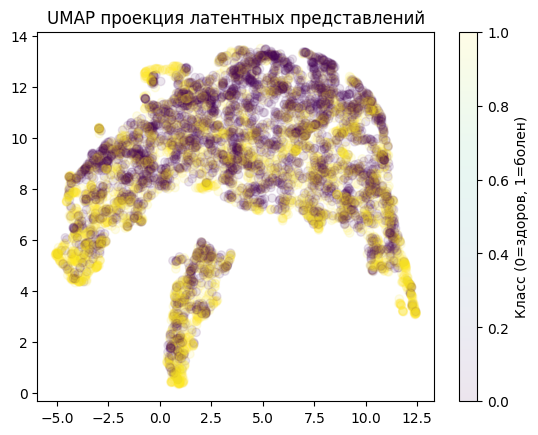

In [ ]:
plt.scatter(
    embeddings_2d[:, 0], 
    embeddings_2d[:, 1],
    c=y,  # Цвета по меткам
    cmap="viridis",
    alpha=0.1
)
plt.colorbar(label="Класс (0=здоров, 1=болен)")
plt.title("UMAP проекция латентных представлений")
plt.show()

In [ ]:
# Кластеризация в 2 кластера (здоров/болен)
kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit_predict(embeddings_avg)

# Оценка совпадения с истинными метками
score = adjusted_rand_score(y.flatten(), clusters)
print(f"Adjusted Rand Index: {score:.2f}")

Adjusted Rand Index: 0.03


In [ ]:
# Кластеризация в 2 кластера (здоров/болен)
scaner = DBSCAN(min_samples=40)
clusters = scaner.fit_predict(embeddings_2d)

# Оценка совпадения с истинными метками
score = adjusted_rand_score(y.flatten(), clusters)
print(f"Adjusted Rand Index: {score:.2f}")

Adjusted Rand Index: 0.02


In [ ]:
embeddings_flatten = embeddings.reshape(embeddings.shape[0], -1)  # [batch, seq_len * hidden_dim]

In [ ]:
reducer = umap.UMAP(n_components=2, random_state=42)
embeddings_2d = reducer.fit_transform(embeddings_flatten)

C:\Users\Админ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


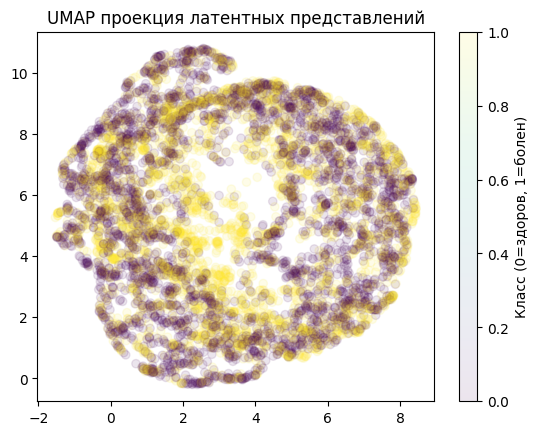

In [ ]:
plt.scatter(
    embeddings_2d[:, 0], 
    embeddings_2d[:, 1],
    c=y,  # Цвета по меткам
    cmap="viridis",
    alpha=0.1
)
plt.colorbar(label="Класс (0=здоров, 1=болен)")
plt.title("UMAP проекция латентных представлений")
plt.show()

In [ ]:
embeddings_flatten = embeddings.reshape(embeddings.shape[0], -1)  # [batch, seq_len * hidden_dim]
# kmeans = KMeans(n_clusters=2).fit(embeddings_flatten)
kmeans = KMeans(n_clusters=2, random_state=2)
clusters = kmeans.fit_predict(embeddings_flatten)

score = adjusted_rand_score(y.flatten(), clusters)
print(f"Adjusted Rand Index: {score:.2f}")

Adjusted Rand Index: 0.00


In [9]:
def umaper(model, x_data, y_data, n_components=2, alpha=0.3):
    model.eval()

    with torch.no_grad():
        embeddings = model.get_embeddings(x_data).numpy()
    
    embeddings_avg = embeddings.mean(axis=1)
    reducer = umap.UMAP(n_components=n_components)
    embeddings_2d = reducer.fit_transform(embeddings_avg)

    num = [331, 332, 333, 334, 335, 336, 337, 338, 339]
    k = 0

    print("UMAP, average")
    for i in range(n_components):
        for j in range(i, n_components):
            if k >= 9:
                k = 0
                plt.show()
                plt.figure()
            plt.subplot(num[k])

            plt.scatter(
                embeddings_2d[:, i], 
                embeddings_2d[:, j],
                c=y_data,  # Цвета по y_data
                cmap="viridis",
                alpha=alpha
            )
            plt.xlabel(f"feature_{i}")
            plt.ylabel(f"feature_{j}")
            k += 1
    
    if k != 9:
        plt.show()
    
    k = 0

    embeddings_flatten = embeddings.reshape(embeddings.shape[0], -1)

    reducer = umap.UMAP(n_components=n_components)
    embeddings_2d = reducer.fit_transform(embeddings_flatten)

    print("UMAP, flatten")
    for i in range(n_components):
        for j in range(i, n_components):
            if k >= 9:
                k = 0
                plt.show()
                plt.figure()
            plt.subplot(num[k])

            plt.scatter(
                embeddings_2d[:, i], 
                embeddings_2d[:, j],
                c=y_data,  # Цвета по y_data
                cmap="viridis",
                alpha=alpha
            )
            plt.xlabel(f"feature_{i}")
            plt.ylabel(f"feature_{j}")
            k += 1

UMAP, average


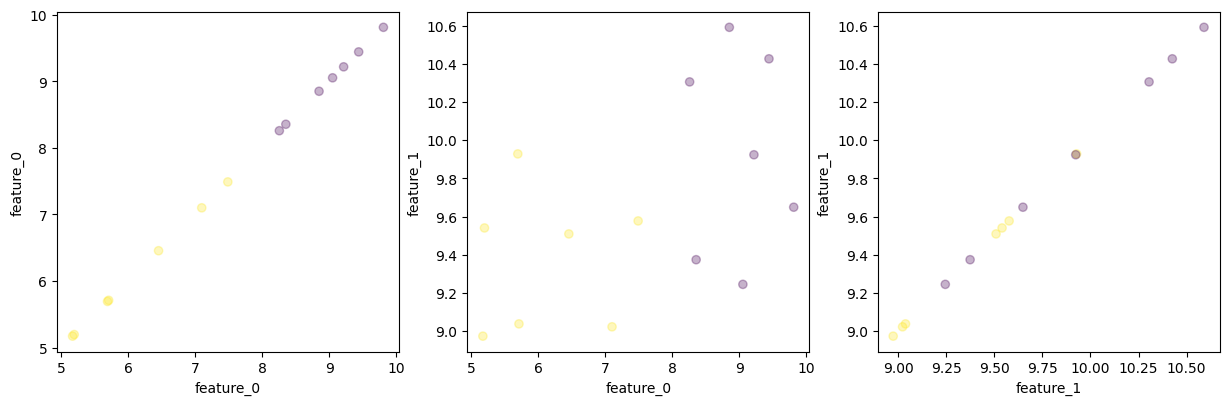

UMAP, flatten


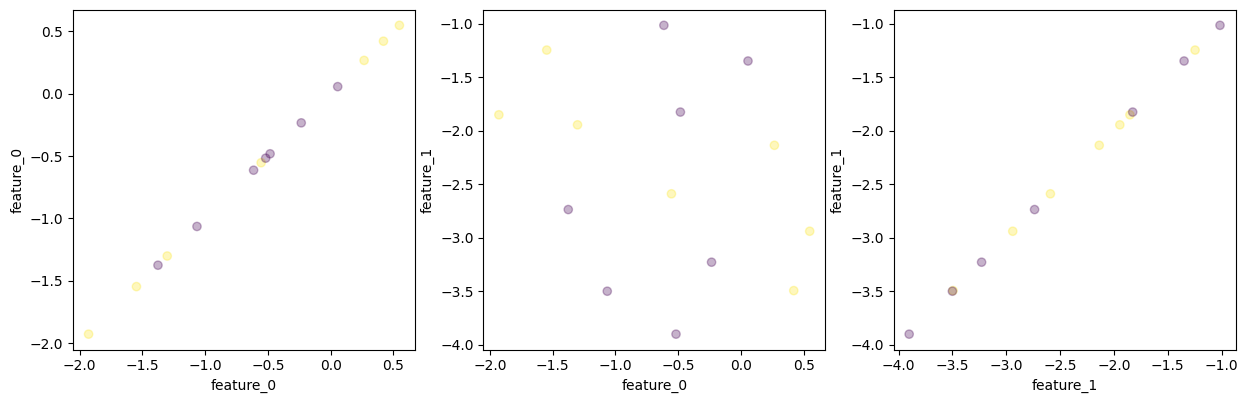

In [10]:
test_data_2 = test_data[0:14]
y_2 = y[0:14]

plt.rcParams['figure.figsize'] = [15, 15]

umaper(model, test_data_2, y_2)

UMAP, average


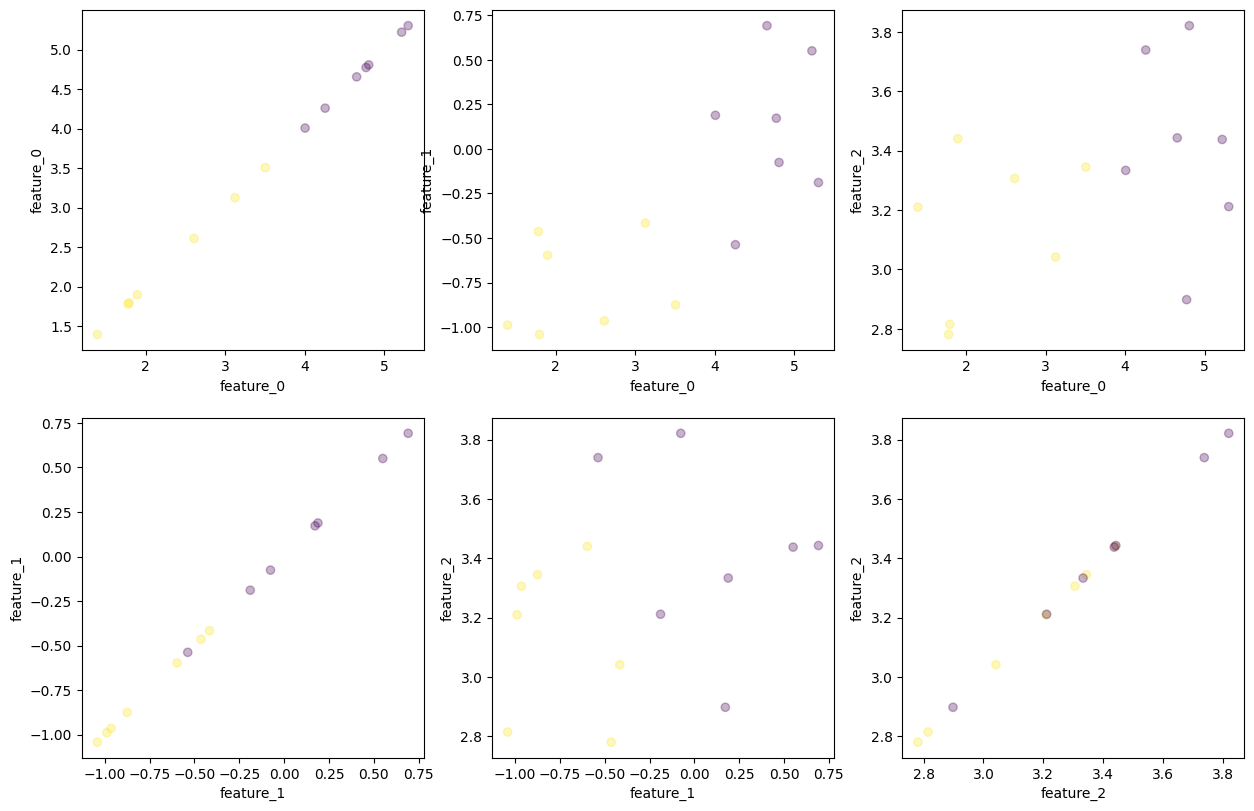

UMAP, flatten


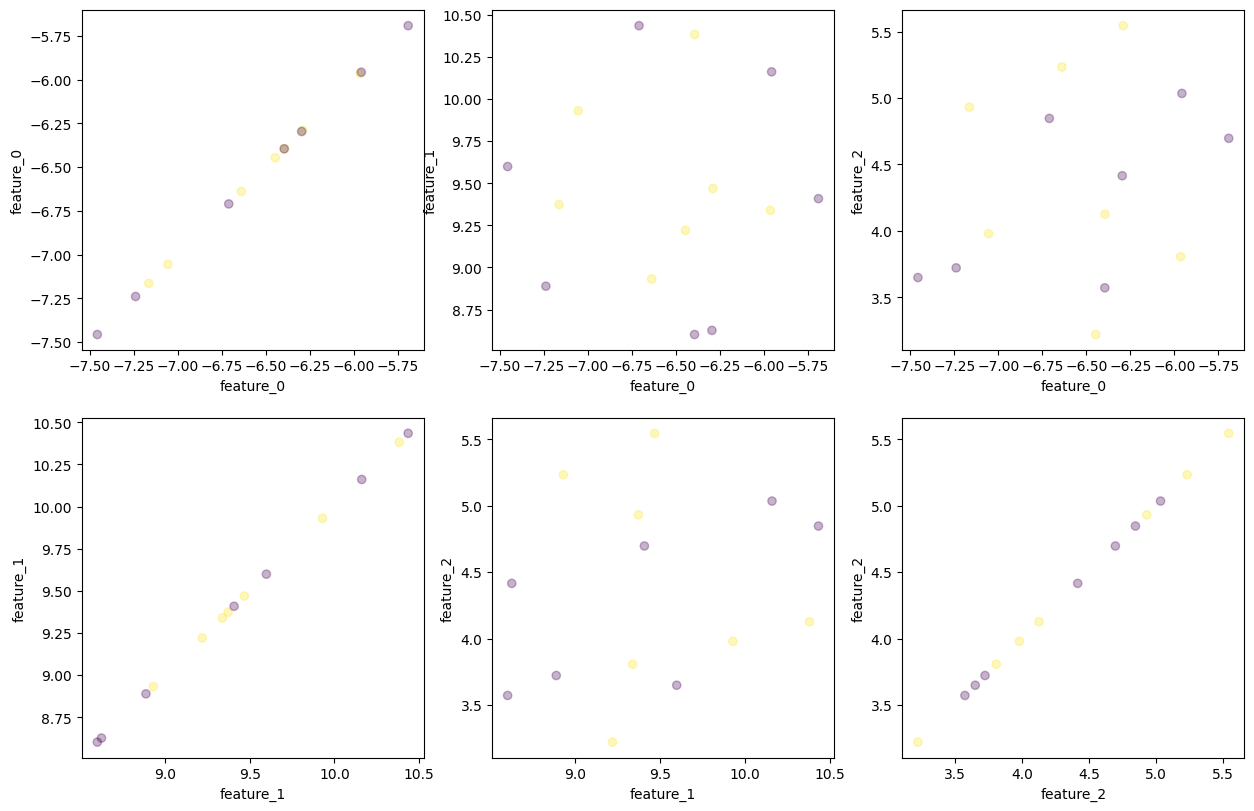

In [11]:
umaper(model, test_data_2, y_2, 3)

UMAP, average


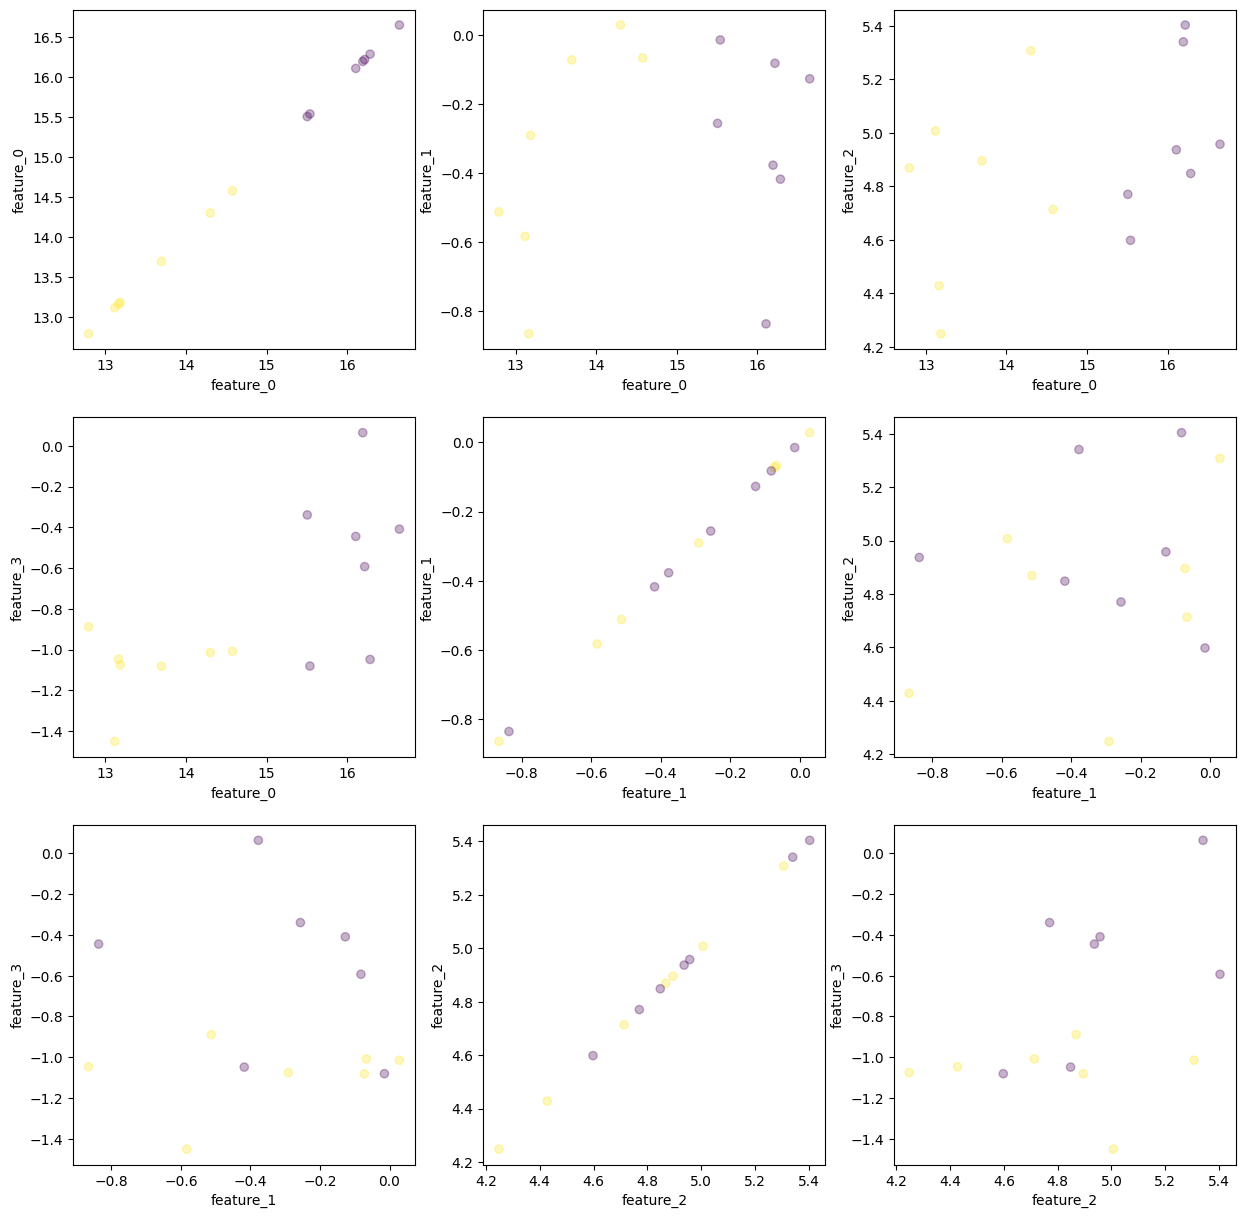

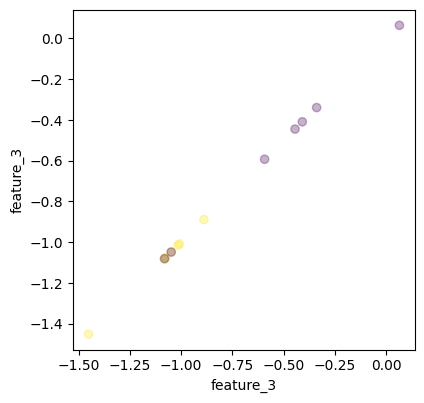

UMAP, flatten


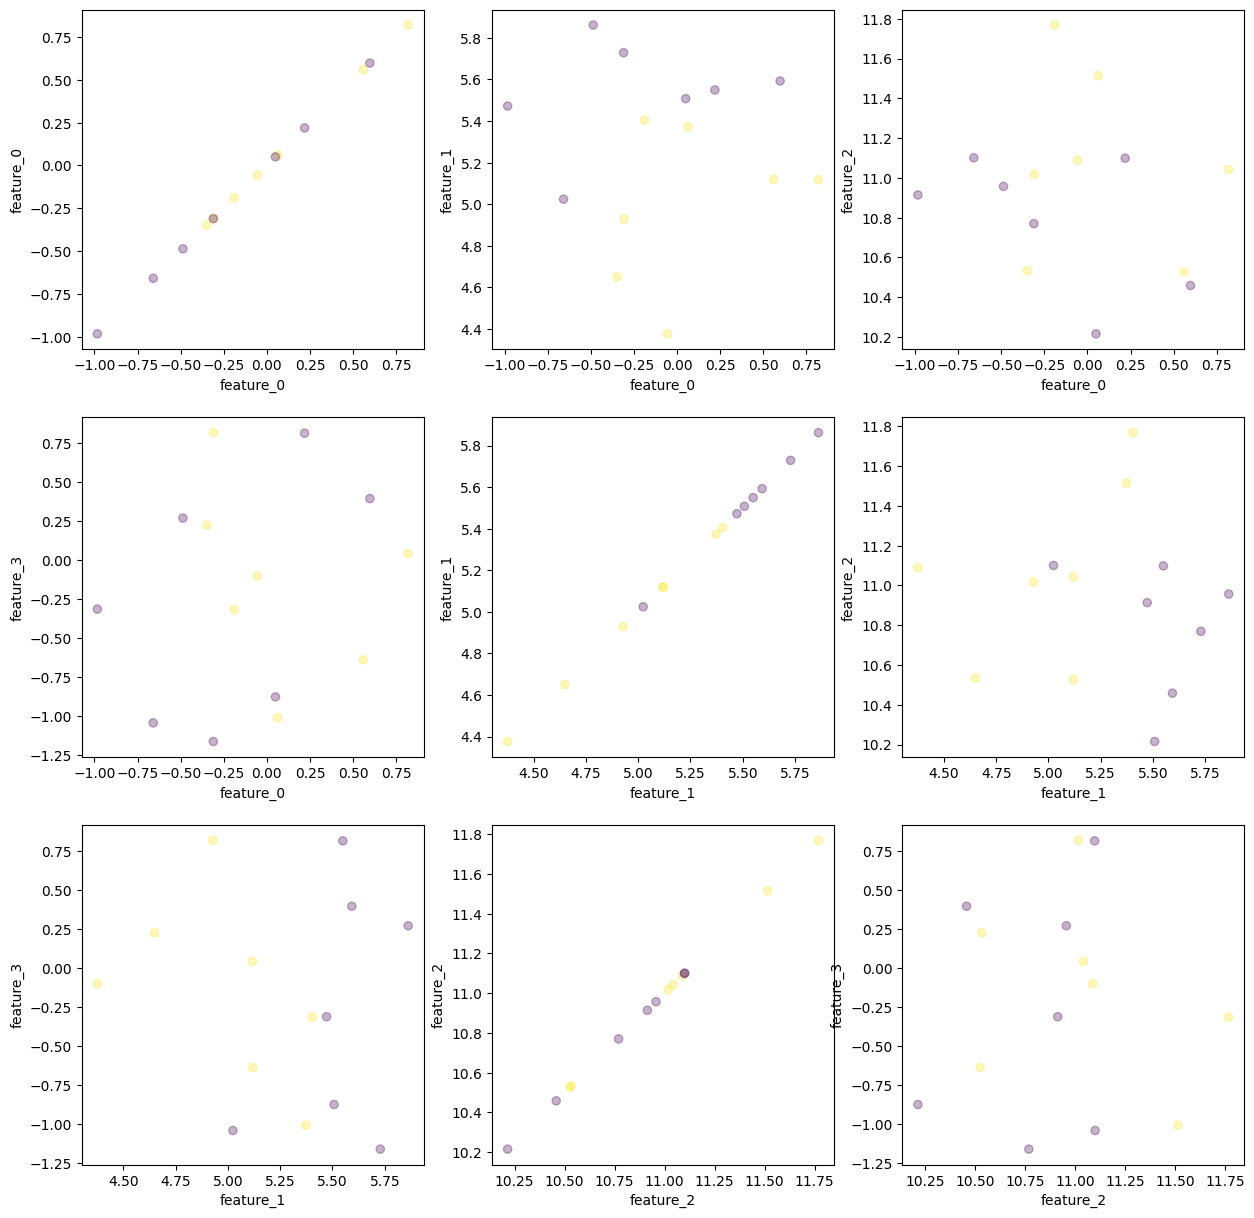

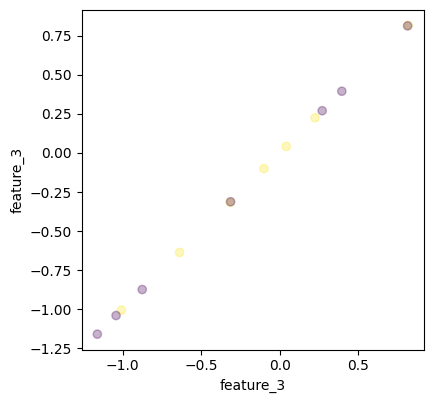

In [12]:
umaper(model, test_data_2, y_2, 4)

UMAP, average


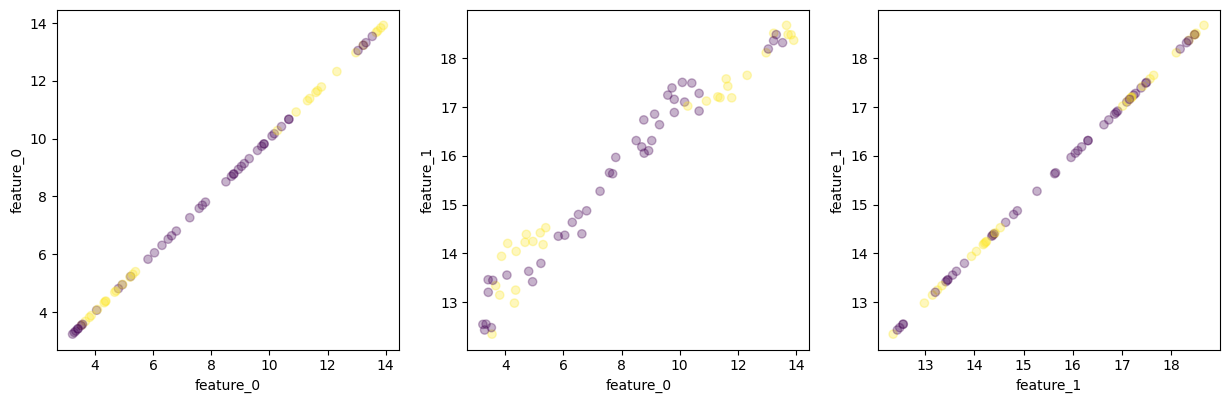

UMAP, flatten


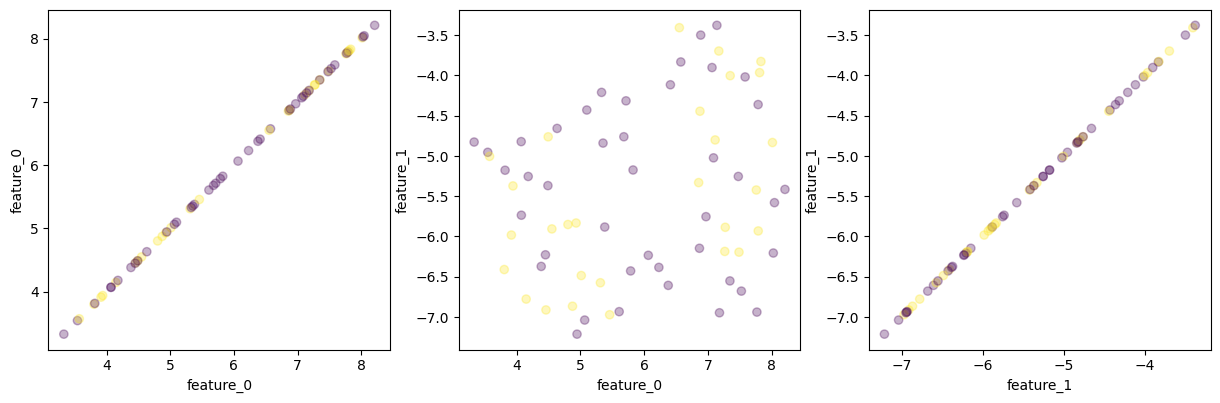

In [15]:
n = 10
n = n * 7
# По моим параметрам (seq_len=5000, window=800, stride=700) на каждую запись приходится 7 окон

test_data_2 = test_data[0:n]
y_2 = y[0:n]

plt.rcParams['figure.figsize'] = [15, 15]

umaper(model, test_data_2, y_2, 2)

UMAP, average


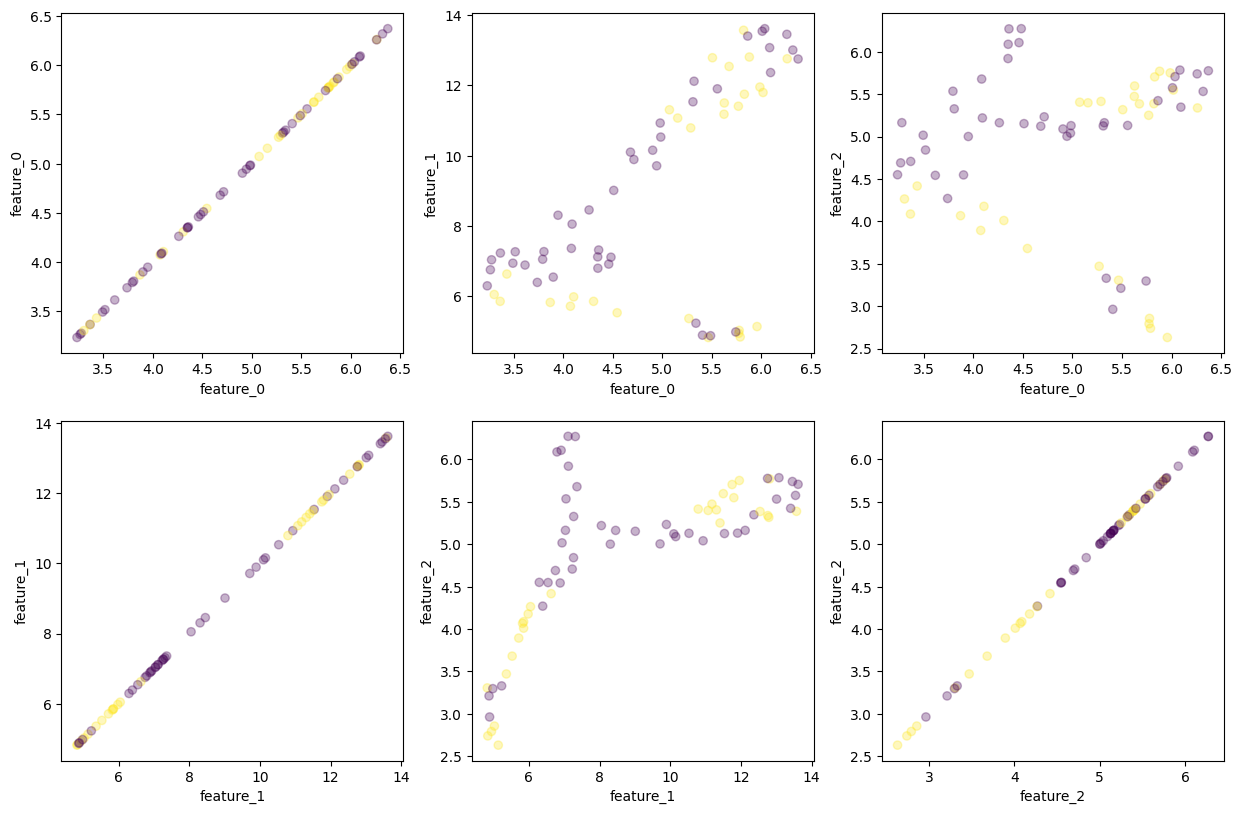

UMAP, flatten


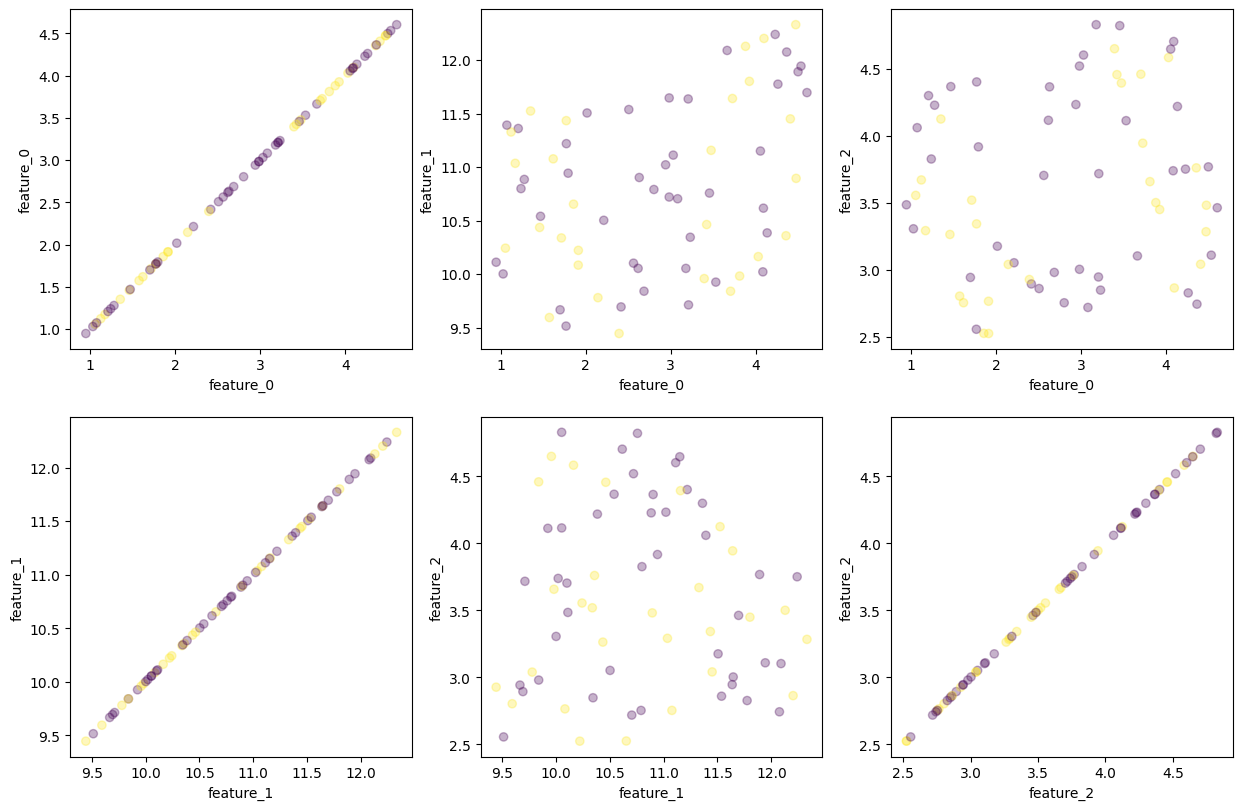

In [16]:
umaper(model, test_data_2, y_2, 3)

UMAP, average


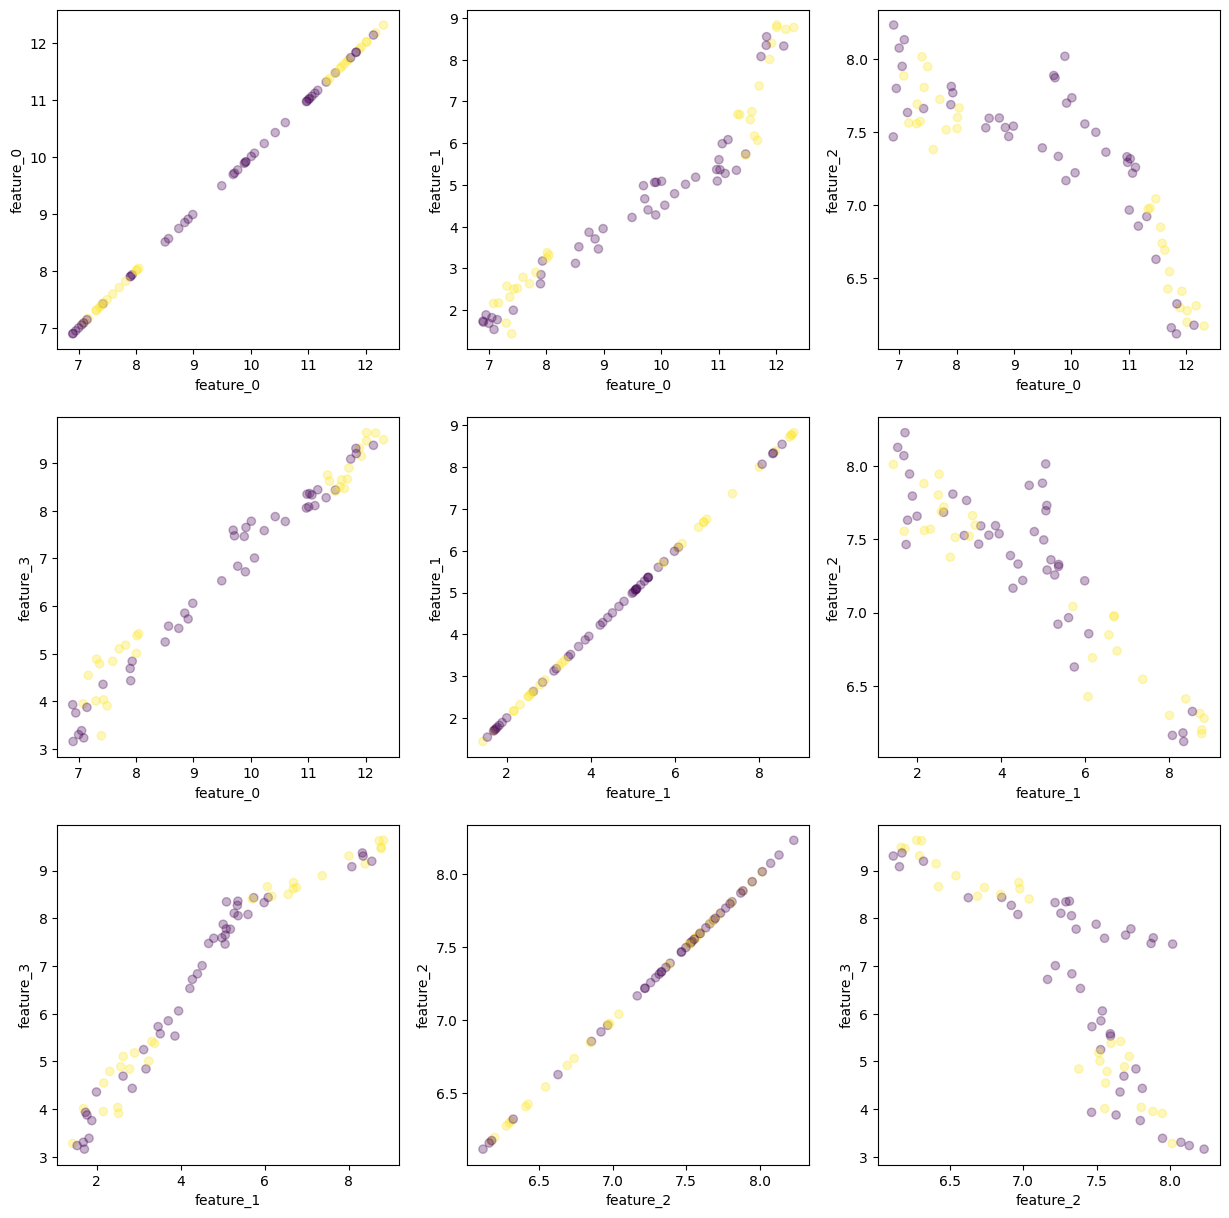

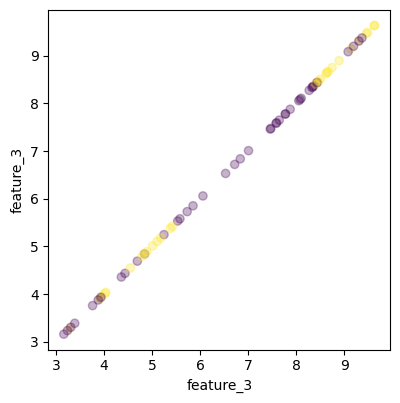

UMAP, flatten


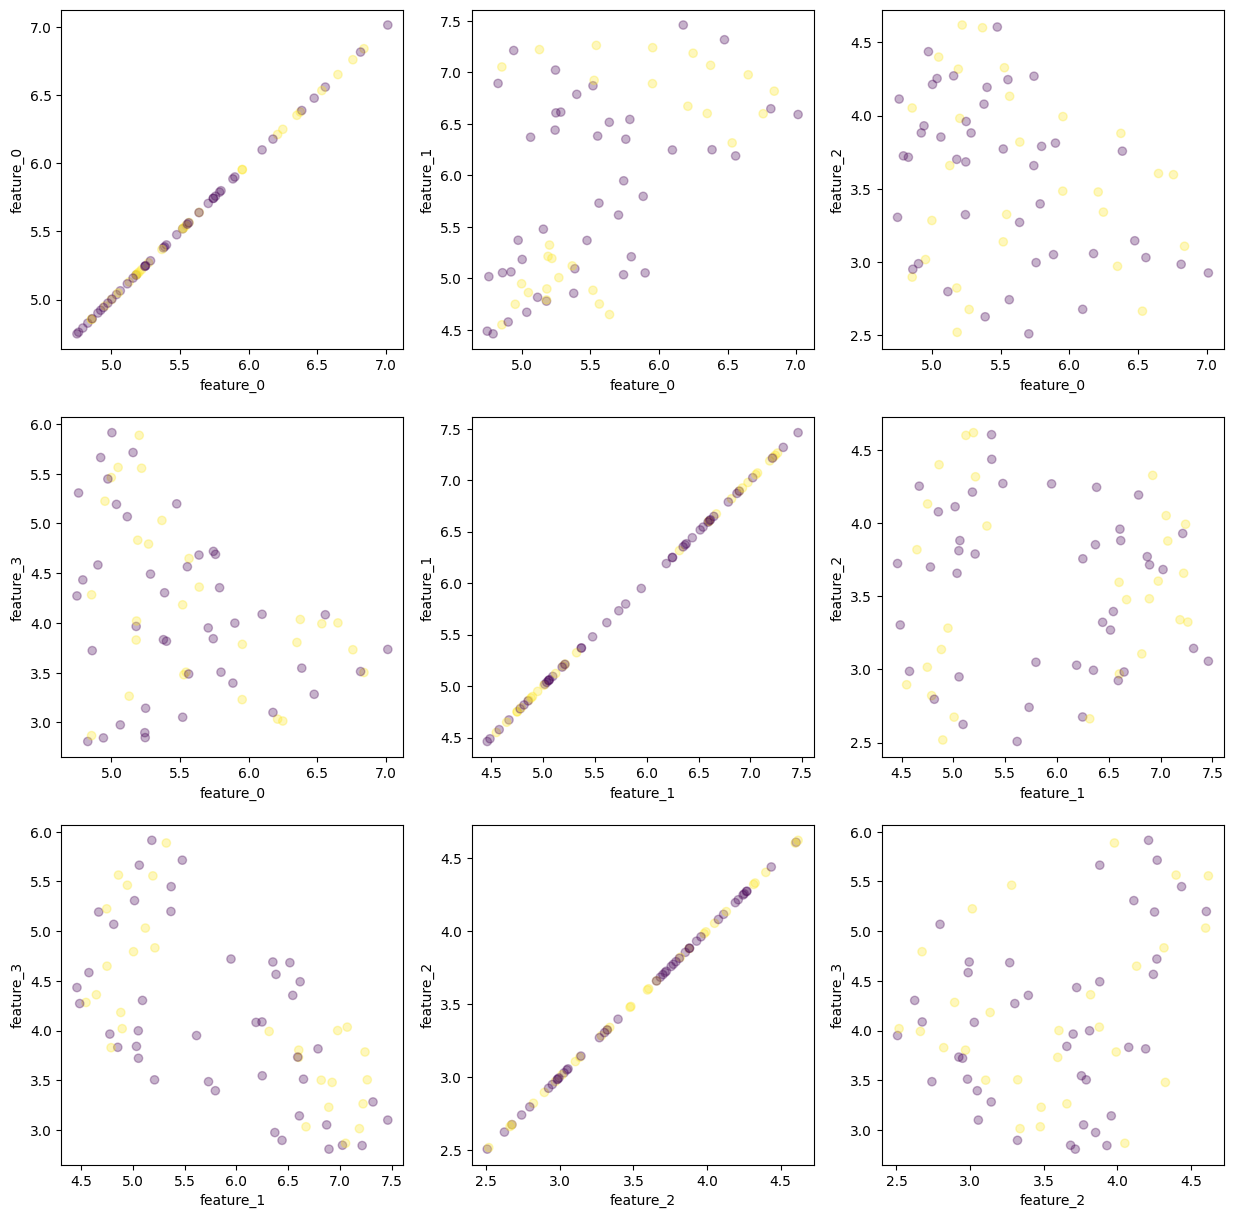

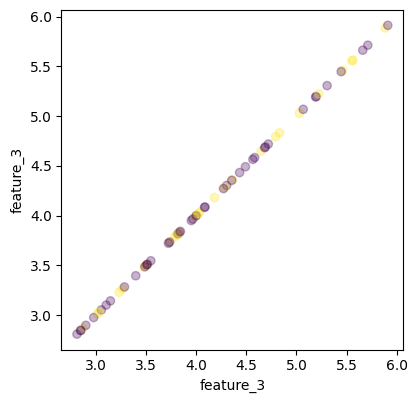

In [17]:
umaper(model, test_data_2, y_2, 4)

In [18]:
def visualize_pca_a(x, y=[]):
    n_components = 4

    pca = PCA(n_components=None)

    X_pca = pca.fit_transform(x)

    explained_variance_ratio = pca.explained_variance_ratio_
    explained_variance_ = pca.explained_variance_

    broken_res = broken_stick(12)

    n = 0

    for i in range(len(explained_variance_ratio)):
        if i >= len(broken_res):
            break
        if broken_res[i] <= explained_variance_ratio[i]:
            n += 1

    print(n, "components for Broken Stick")

    plt.rcParams['figure.figsize'] = [10, 5]

    plt.subplot(121)
    plt.plot(np.arange(1, len(explained_variance_ratio) + 1), explained_variance_ratio, 'r.-', label='Cumulative Explained Variance Ratio')
    plt.plot(np.arange(1, len(broken_res) + 1), broken_res, 'b.-', label='Broken Stick')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Scree Plot with PCA')
    plt.legend()

    len_Kaiser = 0

    normalized_variance = pca.explained_variance_ / pca.explained_variance_.sum()

    for i in normalized_variance:
        if i > 1.0:
            len_Kaiser += 1

    plt.subplot(122)
    plt.plot(np.arange(1, len(explained_variance_) + 1), normalized_variance, 'r.-')
    plt.fill_between([1, len_Kaiser + 0.1], 0, normalized_variance[0], facecolor='lightgray', alpha=0.5)
    plt.xlabel('Principal Component')
    plt.ylabel('Eigenvalue')
    plt.title('Eigenvalues')
    plt.show()

    plt.figure(figsize=(14,7))

def broken_stick(n):
    e_s = []
    e_i = 0
    for i in range(n, 0, -1):
        e_i += 1/i / n
        e_s.append(e_i)
    return e_s[::-1]

2 components for Broken Stick


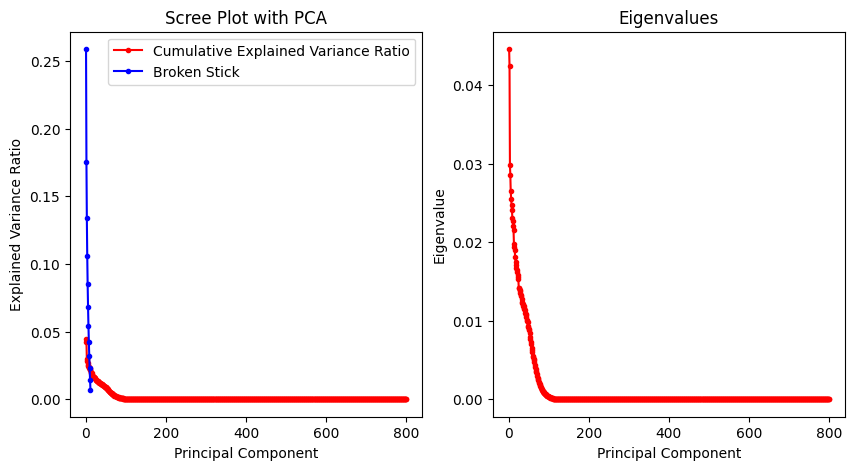

<Figure size 1400x700 with 0 Axes>

In [19]:
visualize_pca_a(test_data.reshape((test_data.shape[0], test_data.shape[1])))

1 components for Broken Stick


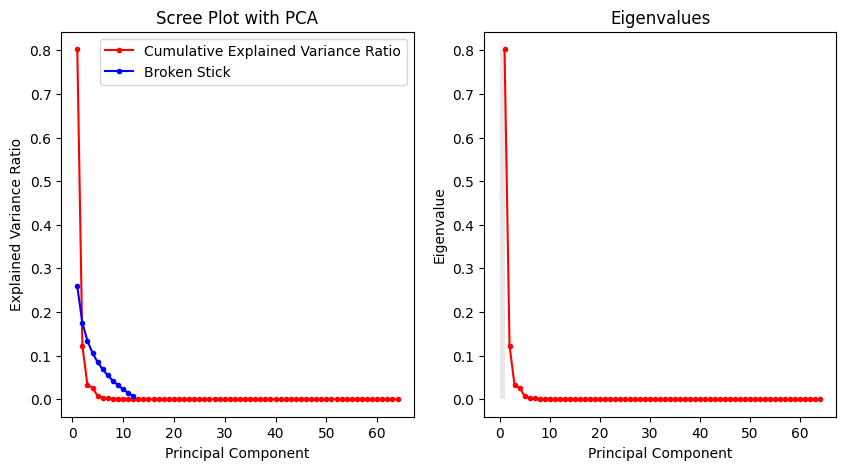

<Figure size 1400x700 with 0 Axes>

In [20]:
model.eval()

n = 10
n = n * 7
# По моим параметрам (seq_len=5000, window=800, stride=700) на каждую запись приходится 7 окон

test_data_2 = test_data[0:n]
y_2 = y[0:n]

with torch.no_grad():
    embeddings = model.get_embeddings(test_data_2).numpy()

visualize_pca_a(embeddings.mean(axis=1))

In [ ]:
# процесс ложится из-за слишком большого числа фич
visualize_pca_a(embeddings_flatten)

In [21]:
def umaper_pca(model, x_data, y_data, n_components=3, alpha=0.3, perplexities=4):
    model.eval()

    with torch.no_grad():
        embeddings = model.get_embeddings(x_data).numpy()
    
    embeddings_avg = embeddings.mean(axis=1)
    reducer = umap.UMAP(n_components=n_components, n_neighbors=perplexities, init="pca")
    embeddings_2d = reducer.fit_transform(embeddings_avg)

    num = [331, 332, 333, 334, 335, 336, 337, 338, 339]
    k = 0

    print("UMAP-PCA, average")
    for i in range(n_components):
        for j in range(i, n_components):
            if k >= 9:
                k = 0
                plt.show()
                plt.figure()
            plt.subplot(num[k])

            plt.scatter(
                embeddings_2d[:, i], 
                embeddings_2d[:, j],
                c=y_data,  # Цвета по y_data
                cmap="viridis",
                alpha=alpha
            )
            plt.xlabel(f"feature_{i}")
            plt.ylabel(f"feature_{j}")
            k += 1
    
    if k != 9:
        plt.show()
    
    k = 0

    embeddings_flatten = embeddings.reshape(embeddings.shape[0], -1)

    reducer = umap.UMAP(n_components=n_components, n_neighbors=perplexities, init="pca")
    embeddings_2d = reducer.fit_transform(embeddings_flatten)

    print("UMAP-PCA, flatten")
    for i in range(n_components):
        for j in range(i, n_components):
            if k >= 9:
                k = 0
                plt.show()
                plt.figure()
            plt.subplot(num[k])

            plt.scatter(
                embeddings_2d[:, i], 
                embeddings_2d[:, j],
                c=y_data,  # Цвета по y_data
                cmap="viridis",
                alpha=alpha
            )
            plt.xlabel(f"feature_{i}")
            plt.ylabel(f"feature_{j}")
            k += 1

UMAP-PCA, average


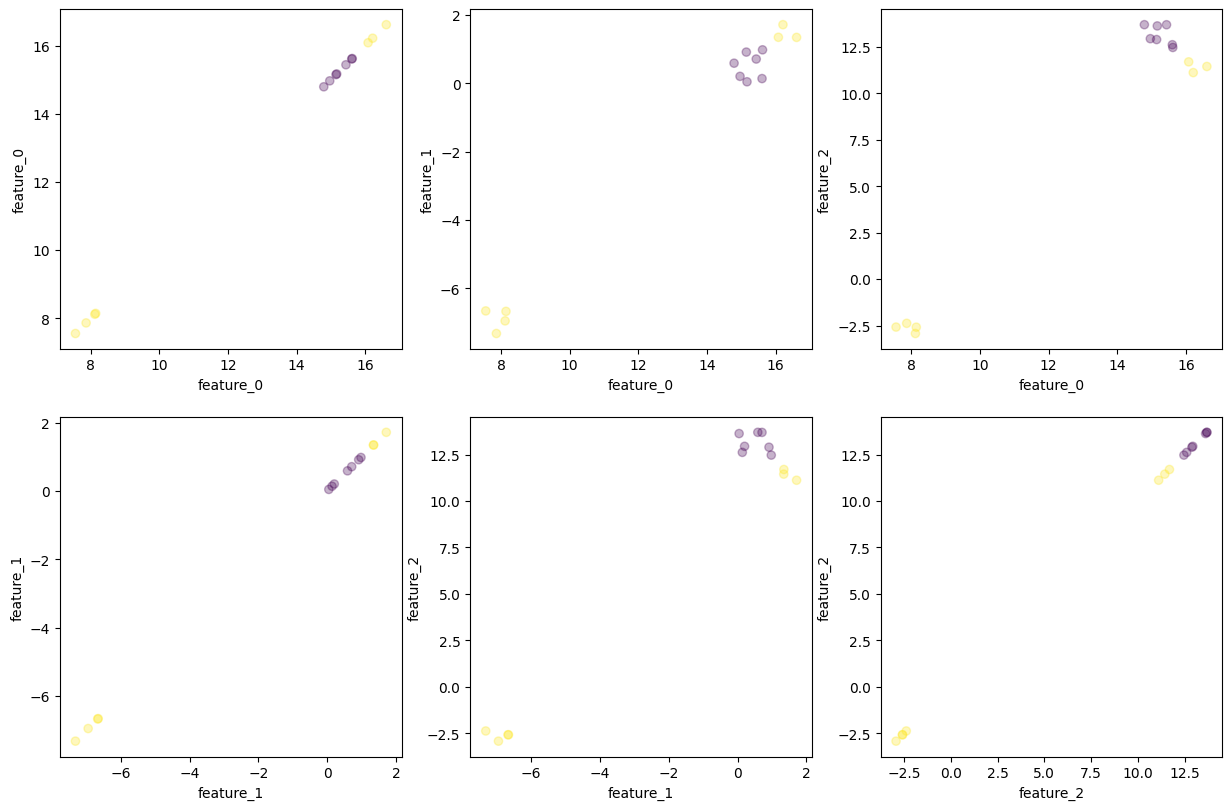

UMAP-PCA, flatten


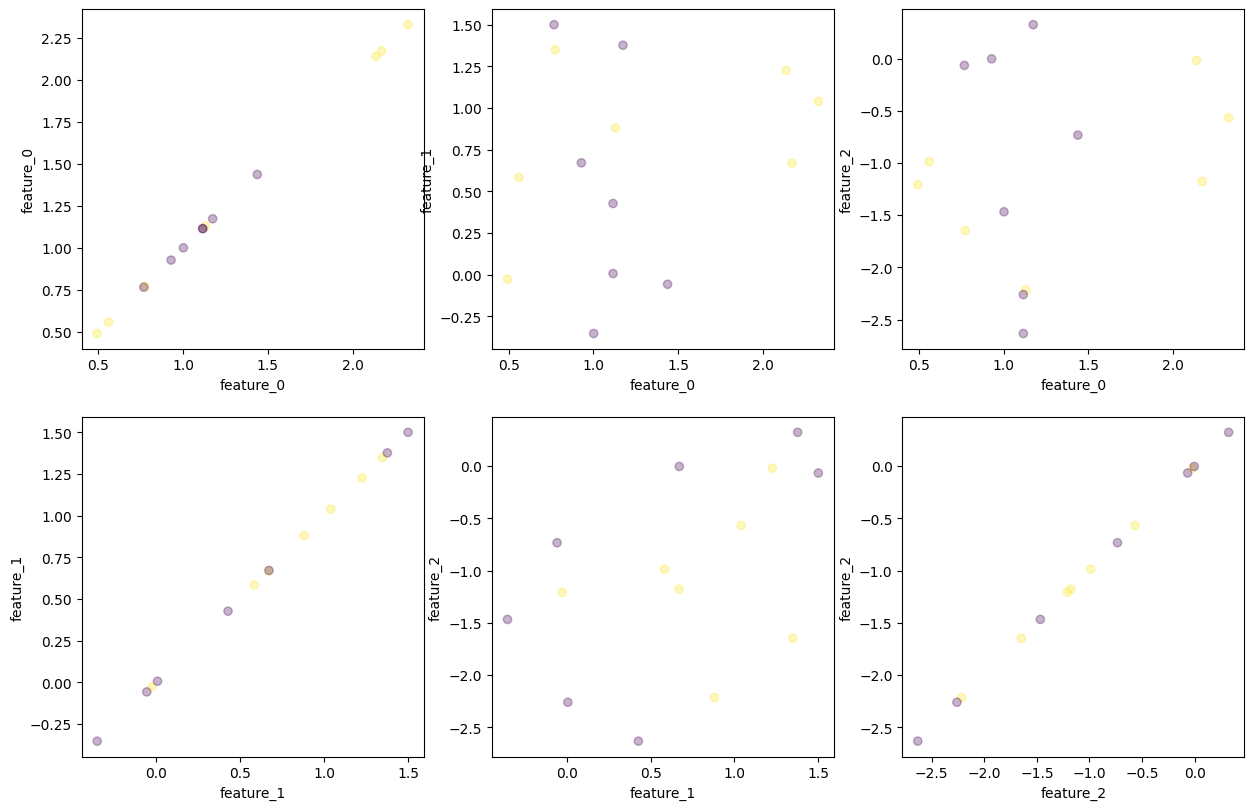

In [23]:
n = 2
n = n * 7
# По моим параметрам (seq_len=5000, window=800, stride=700) на каждую запись приходится 7 окон

test_data_2 = test_data[0:n]
y_2 = y[0:n]

plt.rcParams['figure.figsize'] = [15, 15]

umaper_pca(model, test_data_2, y_2)

Вот тут интересно.

Здесь только два пациента, один здоровый и один больной.

В первом случае average мы видим, что эмбединги больного раскинуты на две стороны, так сказать. Значит, надо их усреднить ещё раз, уже внутри одного пациента.

In [59]:
def umaper_pca_patient_average(model, x_data, y_data, n_components=3, alpha=0.3, perplexities=4):
    model.eval()

    with torch.no_grad():
        embeddings = model.get_embeddings(x_data).numpy()
    
    embeddings_avg = embeddings.mean(axis=1)

    embeddings_avg_patient = []

    for i in range(0, len(embeddings_avg), 7):
        embeddings_avg_patient.append((embeddings_avg[i:i+7].sum(axis=0) / 7).tolist())

    embeddings_avg_patient = np.array(embeddings_avg_patient)

    reducer = umap.UMAP(n_components=n_components, n_neighbors=perplexities, init="pca")

    print(embeddings_avg_patient.shape)

    embeddings_2d = reducer.fit_transform(embeddings_avg_patient)

    print(embeddings_2d.shape)

    num = [331, 332, 333, 334, 335, 336, 337, 338, 339]
    k = 0

    print("UMAP-PCA, average")
    for i in range(n_components):
        for j in range(i, n_components):
            if k >= 9:
                k = 0
                plt.show()
                plt.figure()
            plt.subplot(num[k])

            plt.scatter(
                embeddings_2d[:, i], 
                embeddings_2d[:, j],
                c=y_data,  # Цвета по y_data
                cmap="viridis",
                alpha=alpha
            )
            plt.xlabel(f"feature_{i}")
            plt.ylabel(f"feature_{j}")
            k += 1
    
    if k != 9:
        plt.show()
    
    # k = 0

    # embeddings_flatten = embeddings.reshape(embeddings.shape[0], -1)

    # reducer = umap.UMAP(n_components=n_components, n_neighbors=perplexities, init="pca")
    # embeddings_2d = reducer.fit_transform(embeddings_flatten)

    # print("UMAP-PCA, flatten")
    # for i in range(n_components):
    #     for j in range(i, n_components):
    #         if k >= 9:
    #             k = 0
    #             plt.show()
    #             plt.figure()
    #         plt.subplot(num[k])

    #         plt.scatter(
    #             embeddings_2d[:, i], 
    #             embeddings_2d[:, j],
    #             c=y_data,  # Цвета по y_data
    #             cmap="viridis",
    #             alpha=alpha
    #         )
    #         plt.xlabel(f"feature_{i}")
    #         plt.ylabel(f"feature_{j}")
    #         k += 1

(8, 64)
(8, 3)
UMAP-PCA, average


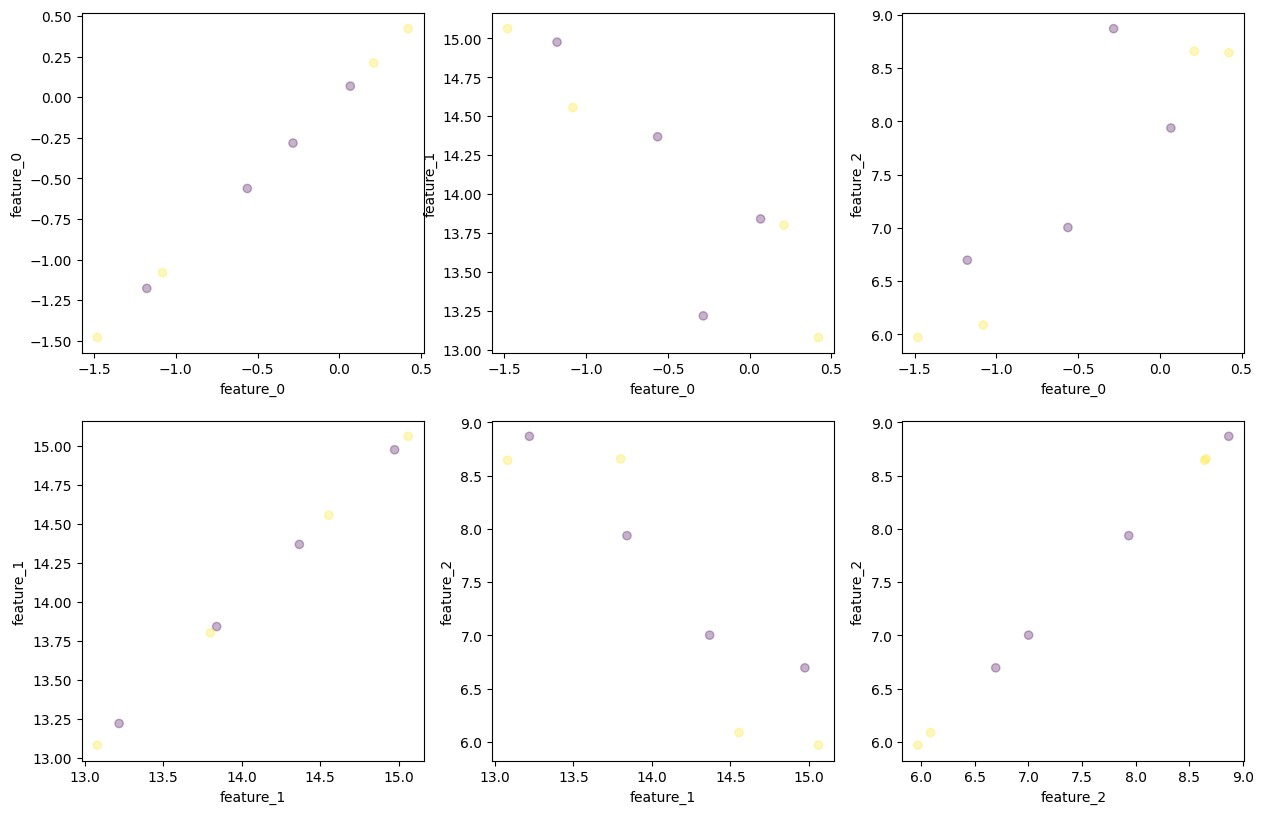

In [64]:
n_ = 8
n = n_ * 7

test_data_2 = test_data[0:n]
y_2 = y[0:n:7]

plt.rcParams['figure.figsize'] = [15, 15]

umaper_pca_patient_average(model, test_data_2, y_2)

UMAP-PCA, average


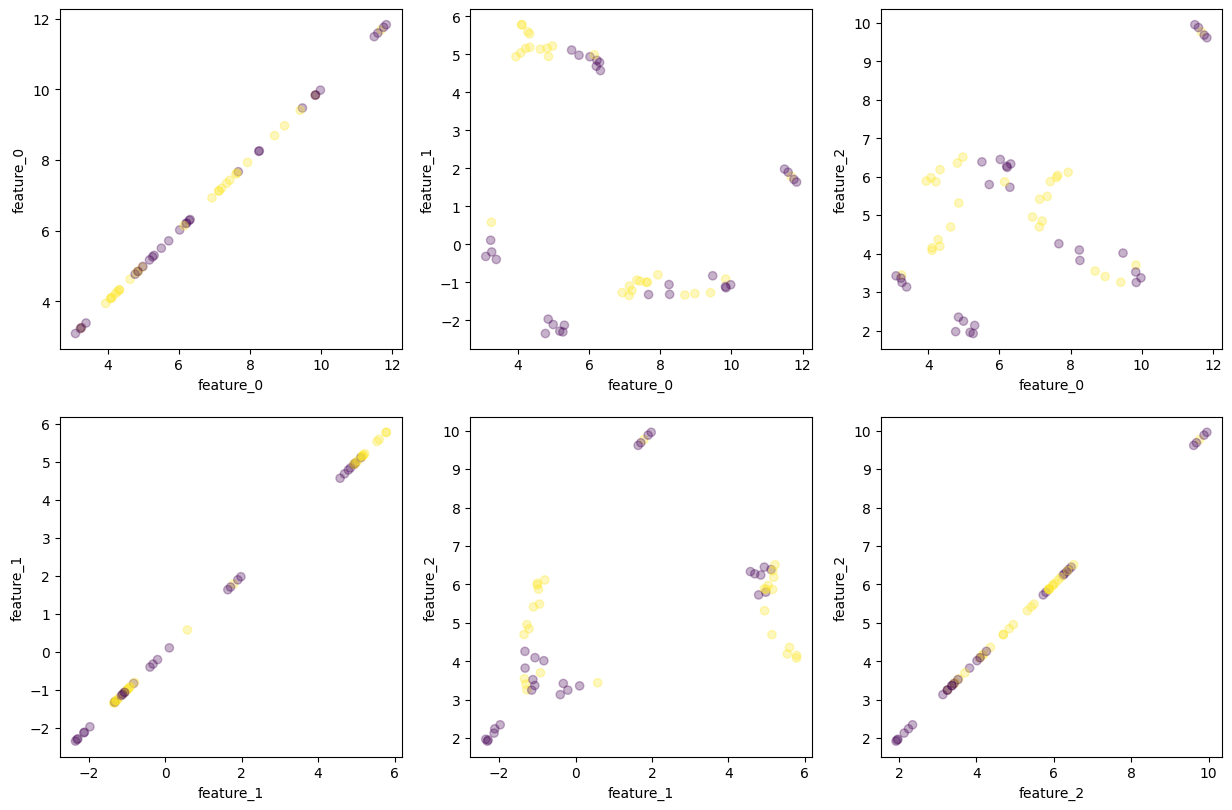

UMAP-PCA, flatten


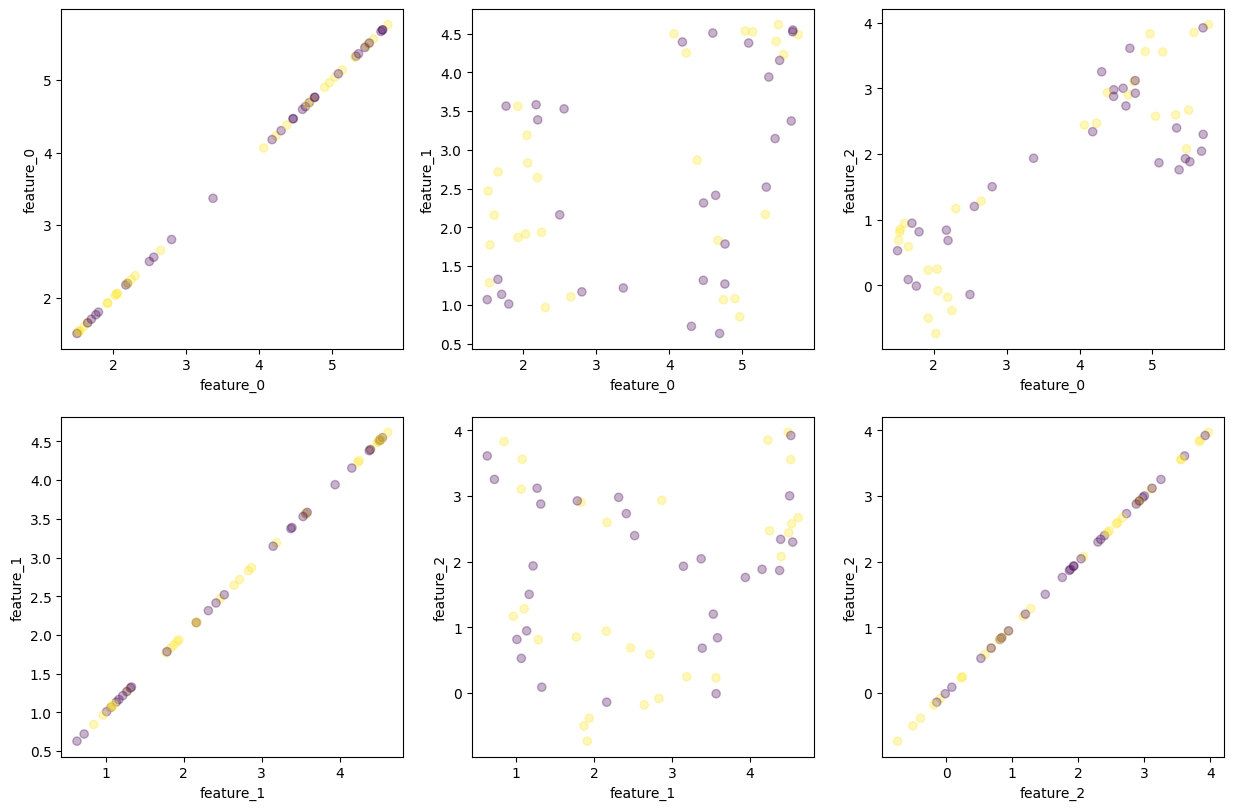

In [65]:
n_ = 8
n = n_ * 7

test_data_2 = test_data[0:n]
y_2 = y[0:n]

plt.rcParams['figure.figsize'] = [15, 15]

umaper_pca(model, test_data_2, y_2)

(1000, 64)
(1000, 3)
UMAP-PCA, average


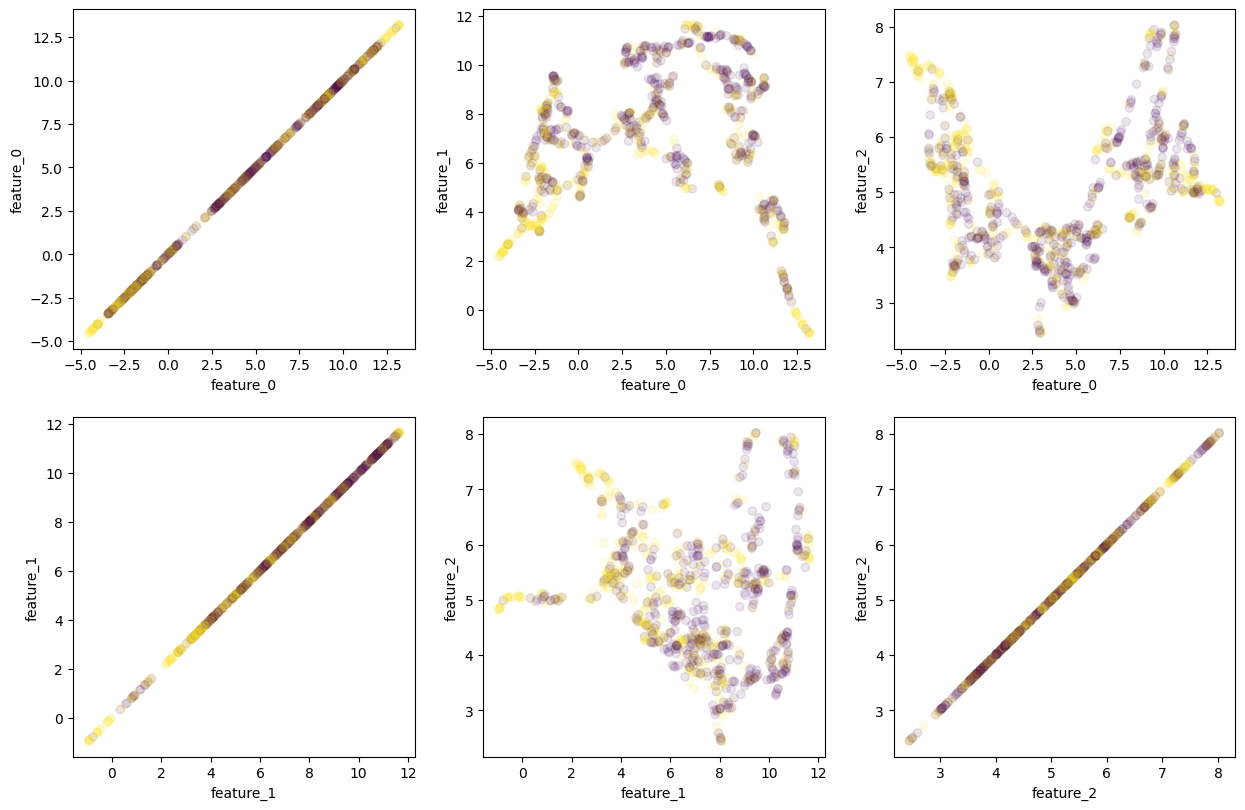

In [78]:
n_ = 1000
n = n_ * 7

test_data_2 = test_data[0:n]
y_2 = y[0:n:7]

plt.rcParams['figure.figsize'] = [15, 15]

umaper_pca_patient_average(model, test_data_2, y_2, perplexities=5, alpha=0.1)

(1000, 64)
(1000, 4)
UMAP-PCA, average


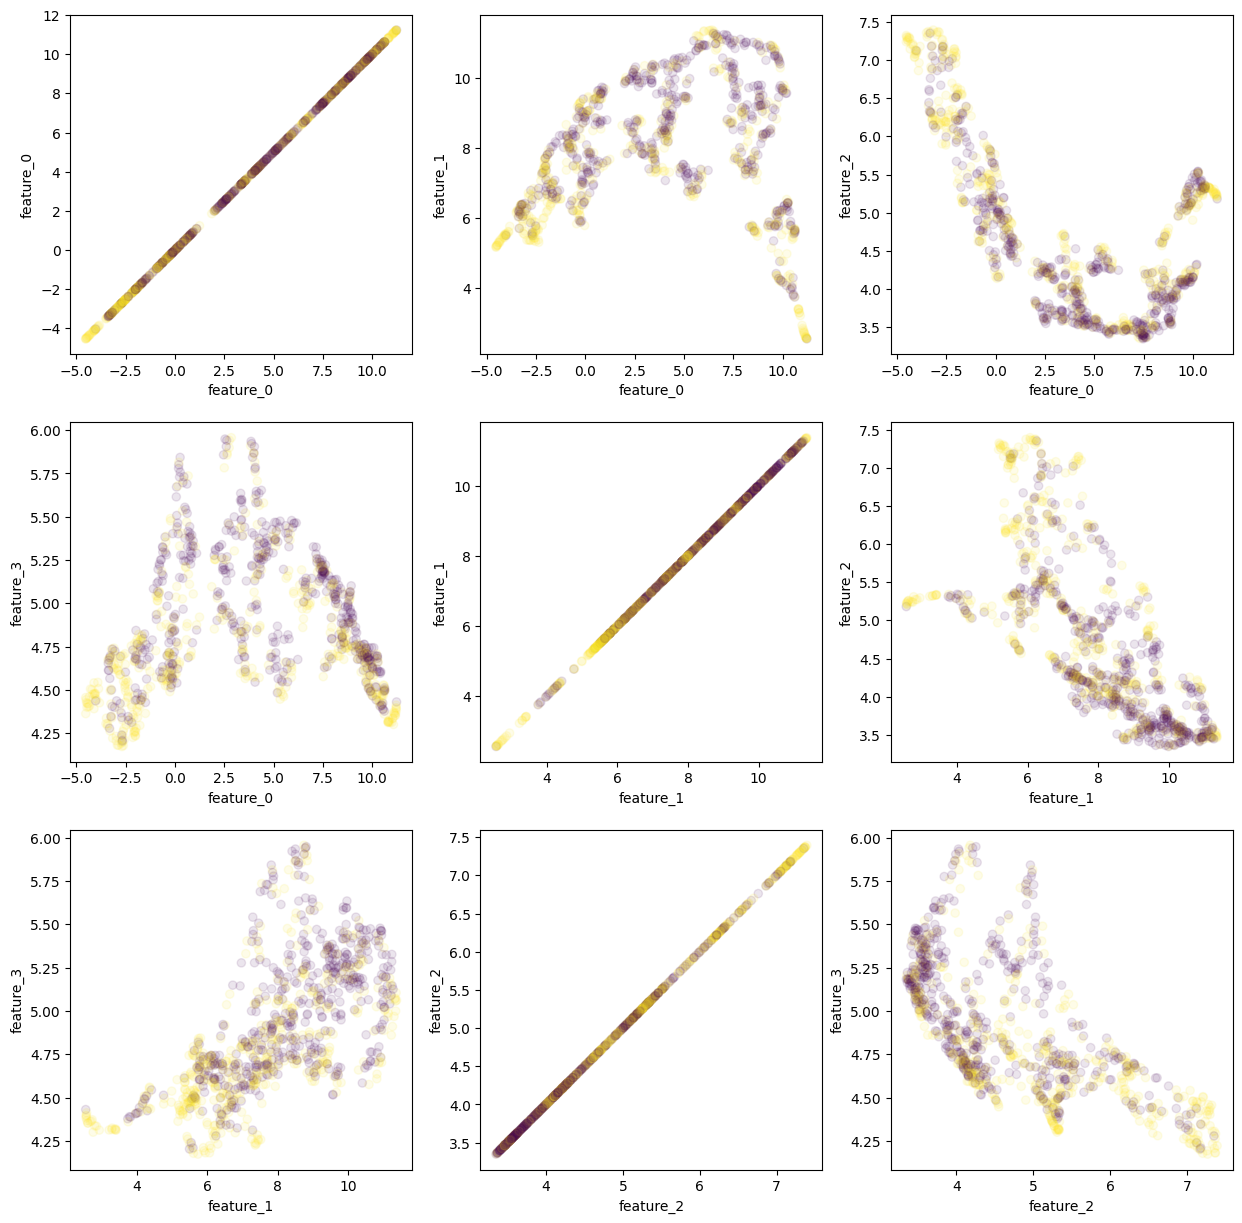

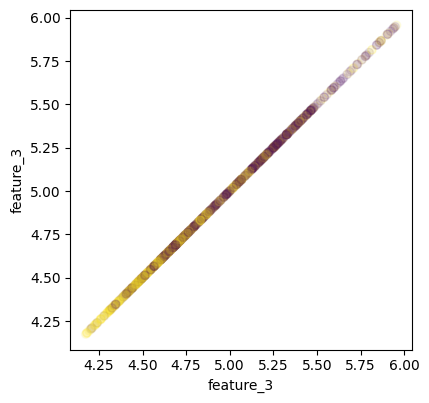

In [77]:
n_ = 1000
n = n_ * 7

test_data_2 = test_data[0:n]
y_2 = y[0:n:7]

plt.rcParams['figure.figsize'] = [15, 15]

umaper_pca_patient_average(model, test_data_2, y_2, 4, perplexities=10, alpha=0.1)